# Forest Cover Type Dataset

#### **Project Purpose**
My purpose is to gets hands-on with data science and in the process:
- Learn new data science tasks (end-to-end), tools and techniques
- Document learnings so it can be repeated/updated and industrialized.

**Note:** Since the purpose is learning, the steps and investigations are a little elaborate and fail attempts with a new approach are also left as is with notes.

**Step 1: Problem Understanding & Objective Setting** 
**Step 2: Data Overview & Preprocessing** 
**Step 3: Exploratory Data Analysis (EDA)**  
**Step 4: Feature Engineering & Selection**  
**Step 5: Baseline Model and Preprocessing** 
**Step 6: Model Training & Optimization** 

- **XGBoost**
- **SVM**
- **LightGBM**

**Step 7: Model Evaluation & Interpretation**  
**Step 8: Discussion and Conclusion** 
**Step 9: Deployment & Model Monitoring**  

**<u>Let's get started</u>**

##### Forest Cover Type - About Dataset
**Context**
This dataset contains 581K tree observations from four areas of the Roosevelt National Forest in Colorado. All observations are cartographic variables (no remote sensing) from 30 meter x 30 meter sections of forest. There are over half a million measurements total!

**Content**
This dataset includes information on tree type, shadow coverage, distance to nearby landmarks (roads etcetera), soil type, and local topography.

**Acknowledgement**
This dataset is part of the UCI Machine Learning Repository. The original database owners are Jock A. Blackard, Dr. Denis J. Dean, and Dr. Charles W. Anderson of the Remote Sensing and GIS Program at Colorado State University.
Link (https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset)

Link <a id="step-1"></a>

### **Step 1: Problem Understanding & Objective Setting**
- Define the goal of the dataset (Classification, Regression, Clustering, etc.)
- Identify success metrics (Accuracy, F1-score, RMSE, etc.)
- Understand potential constraints (computation limits, class imbalance, etc.)
---
- Objective: A model that predicts what types of trees grow in an area based on the surrounding characteristics
- Type: Multi-Class Classification
- Success metrics: F1-score, Confusion Matrix, ROC-AUC
- Notable Constraints: Noted below

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("./data/covtype.csv")  # Update with actual file path
df.shape

(581012, 55)

In [3]:
# Target column
target_column = "Cover_Type" 

# Count class occurrences and percentage
class_counts = df[target_column].value_counts()
class_percentages = df[target_column].value_counts(normalize=True) * 100

# Print class counts and percentages
class_distribution = pd.DataFrame({"Count": class_counts, "Percentage (%)": class_percentages})
print("Class Distribution:\n", class_distribution)

Class Distribution:
     Count  Percentage (%)
2  283301       48.759922
1  211840       36.460521
3   35754        6.153746
7   20510        3.530048
6   17367        2.989095
5    9493        1.633873
4    2747        0.472796


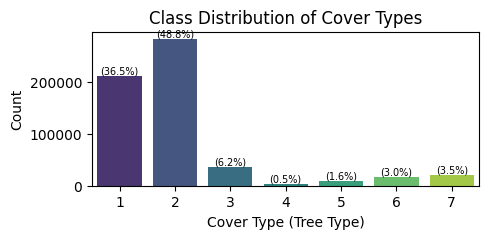

In [4]:
# Plot class distribution
plt.figure(figsize=(5, 2))
ax = sns.countplot(x=df[target_column], palette="viridis")

# Add data labels for absolute values and percentages
for p in ax.patches:
    height = p.get_height()
    percentage = (height / df.shape[0]) * 100  # Convert count to percentage
    ax.annotate(f"({percentage:.1f}%)",  
                (p.get_x() + p.get_width() / 2., height),  
                ha='center', va='bottom', fontsize=7, color='black')

# Labels and title
plt.xlabel("Cover Type (Tree Type)")
plt.ylabel("Count")
plt.title("Class Distribution of Cover Types")
plt.show()

Inference:
- Class Imbalance: Cover Types 1 and 2 dominate (~85% of the dataset), while Cover Types 4, 5, 6, and 7 are underrepresented.
- Potential Issues:
    - Models may favor predicting the majority classes (1 & 2) while struggling with the minority classes (4 & 5).
    - Evaluation metrics like accuracy may be misleading. Instead, metrics like F1-score or a confusion matrix will be more informative.

---
---

<a id="step-2"></a>

### **Step 2: Data Exploration & Preprocessing**

Data Overview
- Check dataset structure (shape, types, missing values, duplicates)
- Compute summary statistics (mean, median, distribution analysis)

Preprocessing
- Handle missing values & outliers
- Encode categorical variables (One-Hot, Label Encoding)
- Scale/normalize numerical features if needed
---


In [4]:
df.head(3) #head() is great start to get sense of the data
# data.tail()
# data.sample(5) #if head() is not representative use sample()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2


In [6]:
# Check dataset shape
print("Dataset Shape:", df.shape)

# Check data types 
# print("\nColumn Data Types:\n", df.dtypes) # There are 55 columns, all of which numeric, summary below. commenting for better readability
# df.info() # info() tells you dtypes and missing values; commenting here for readability but run it look at the results and summarize inferences

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values Per Column:\n", missing_values[missing_values > 0])  # Show only columns with missing values

# Check for duplicates
duplicate_rows = df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_rows)

Dataset Shape: (581012, 55)

Missing Values Per Column:
 Series([], dtype: int64)

Number of Duplicate Rows: 0


**EDA - Columns Summary:**
- 55 columns all of which are int dtype
    - 10 columns are inherently numeric 
    - 44 numeric columns represent 2 categorical data "soil type" and "wilderness area". These have been one-hot encoded into 44 columns of numeric type
    - 1 column is the target column which is categorical

**Inference:**
- Data looks very highly pre-processed and clean  
---
---

<a id="step-3"></a>

### Step 3: Exploratory Data Analysis (EDA)
- Univariate Analysis - Distribution of individual features - (histograms, boxplots)
- Bivariate Analysis - Feature relationships with the target - (scatterplots)
- Correlation Analysis (Finding important relationships) - (correlation heatmap)


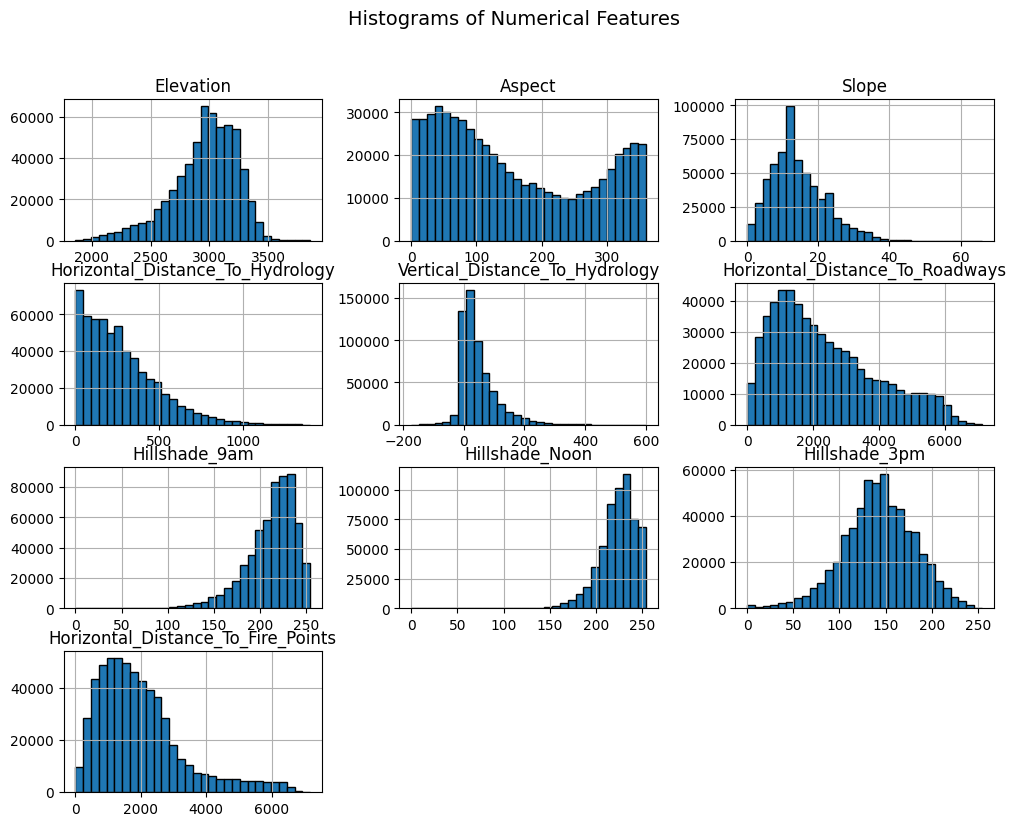

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the 10 inherent numeric columns
numeric_columns = df.iloc[:, :10]  # Assuming first 10 columns are numeric

# Plot histograms
numeric_columns.hist(figsize=(12, 9), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=14)
plt.show()


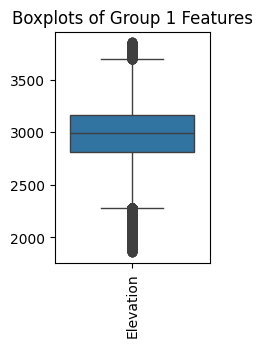

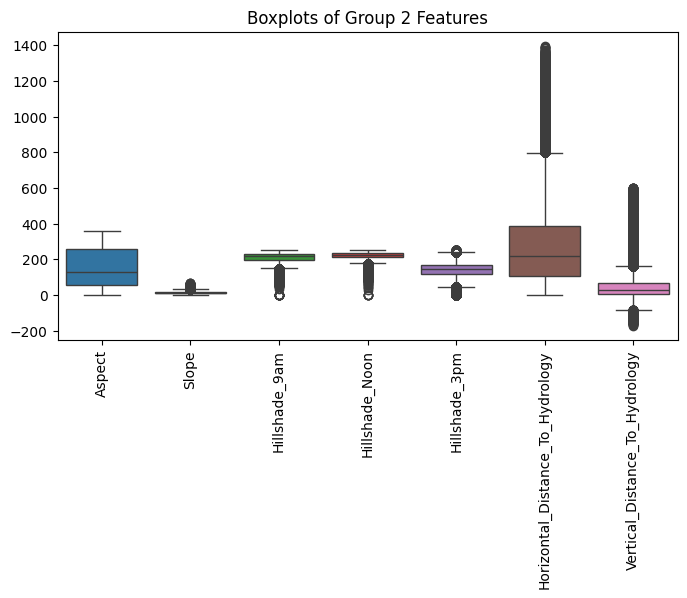

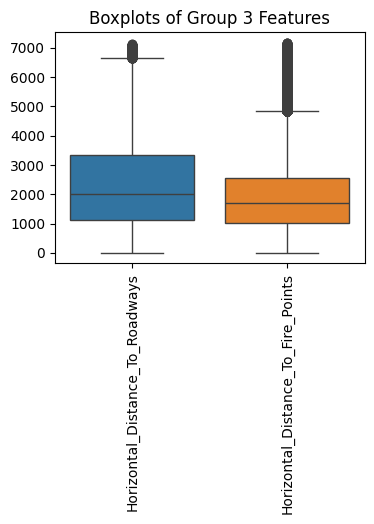

In [8]:
# Manually grouping based on observed scale differences
group_1 = ["Elevation"]
group_2 = ["Aspect", "Slope", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology"]
group_3 = ["Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points"]


# Boxplot for Group 1
plt.figure(figsize=(2, 3))
sns.boxplot(data=df[group_1])
plt.xticks(rotation=90)
plt.title("Boxplots of Group 1 Features")
plt.show()

# Boxplot for Group 2
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[group_2])
plt.xticks(rotation=90)
plt.title("Boxplots of Group 2 Features")
plt.show()

# Boxplot for Group 3
plt.figure(figsize=(4, 3))
sns.boxplot(data=df[group_3])
plt.xticks(rotation=90)
plt.title("Boxplots of Group 3 Features")
plt.show()


 - We see some outliers in the boxplots. Let investigate them. 

In [14]:

def calculate_outlier_percentage(df, columns, method='mean', threshold=3):
    """
    Calculate the percentage of outliers in specified columns using either mean and standard deviation (SD) 
    or median and median absolute deviation (MAD).

    Parameters:
    method (str): 'mean' for mean and SD, 'median' for median and MAD. Default is 'mean'.
    threshold (float): Number of SDs or MADs away from the center to consider as an outlier. Default is 3.

    Returns:
    pd.DataFrame: A dataframe containing column names, center values, spread values, and outlier percentages.
    """
    results = []

    for col in columns:
        data = df[col]

        if method == 'mean':
            center = data.mean()
            spread = data.std()
        elif method == 'median':
            center = data.median()
            spread = np.median(np.abs(data - center))
        else:
            raise ValueError("Invalid method. Choose 'mean' or 'median'")

        # Calculate outliers
        lower_bound = center - threshold * spread
        upper_bound = center + threshold * spread
        outliers = (data < lower_bound) | (data > upper_bound)
        outlier_percentage = (outliers.sum() / len(data)) * 100

        # Append results
        results.append({'Column': col, 'Center': center, 'Spread': spread, 'Outlier_Percentage%': outlier_percentage})

        # print(f"{col}: {outlier_percentage:.2f}% outliers using {method} and {threshold}x spread")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    # print("\nSummary:\n", results_df)
    return results_df



In [26]:
calculate_outlier_percentage(df, ['Elevation','Slope','Aspect','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways', \
                                   'Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Hydrology','Hillshade_3pm', \
                                    'Hillshade_9am','Hillshade_Noon' ], method='mean', threshold=3)

,Column,Center,Spread,Outlier_Percentage%
0,Elevation,2959.365301,279.984734,1.003766
1,Slope,14.103704,7.488242,0.701190
2,Aspect,155.656807,111.913721,0.000000
3,Vertical_Distance_To_Hydrology,46.418855,58.295232,1.731290
4,Horizontal_Distance_To_Roadways,2350.146611,1559.254870,0.005680
5,Horizontal_Distance_To_Fire_Points,1980.291226,1324.195210,1.867948
6,Horizontal_Distance_To_Hydrology,269.428217,212.549356,1.217359
7,Hillshade_3pm,142.528263,38.274529,0.523569
8,Hillshade_9am,212.146049,26.769889,1.293605
9,Hillshade_Noon,223.318716,19.768697,1.218908


Inference: Outliers are small in proportion hence no treatment

In [10]:
numeric_columns.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


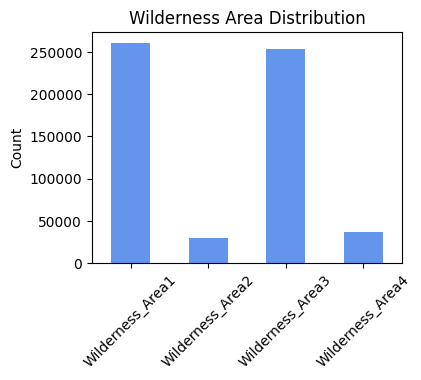

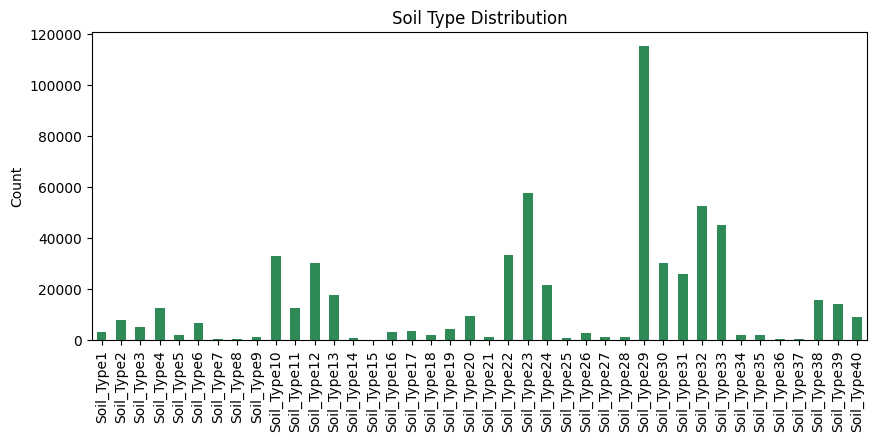

In [7]:
# Plot Wilderness Area distribution (first set of one-hot columns)
wilderness_columns = [col for col in df.columns if "Wilderness" in col]
plt.figure(figsize=(4, 3))
df[wilderness_columns].sum().plot(kind='bar', color='cornflowerblue')
plt.title("Wilderness Area Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Plot Soil Type distribution (second set of one-hot columns)
soil_columns = [col for col in df.columns if "Soil_Type" in col]
plt.figure(figsize=(10, 4))
df[soil_columns].sum().plot(kind='bar', color='seagreen')
plt.title("Soil Type Distribution")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


- Bivariate Analysis

In [36]:
def plot_scatterplots(df, columns, target_column):
    """
    Plot scatterplots of multiple features against the target variable.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    columns (list): List of feature column names.
    target_column (str): Target column name.
    """
    num_cols = len(columns)
    num_rows = (num_cols + 3) // 4  # 4 plots per row

    fig, axs = plt.subplots(num_rows, 4, figsize=(15, 3 * num_rows))
    axs = axs.flatten()

    for i, col in enumerate(columns):
        sns.scatterplot(x=df[col], y=df[target_column], ax=axs[i])
        axs[i].set_title(f'{col} vs {target_column}')

    # Hide unused subplots if any
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


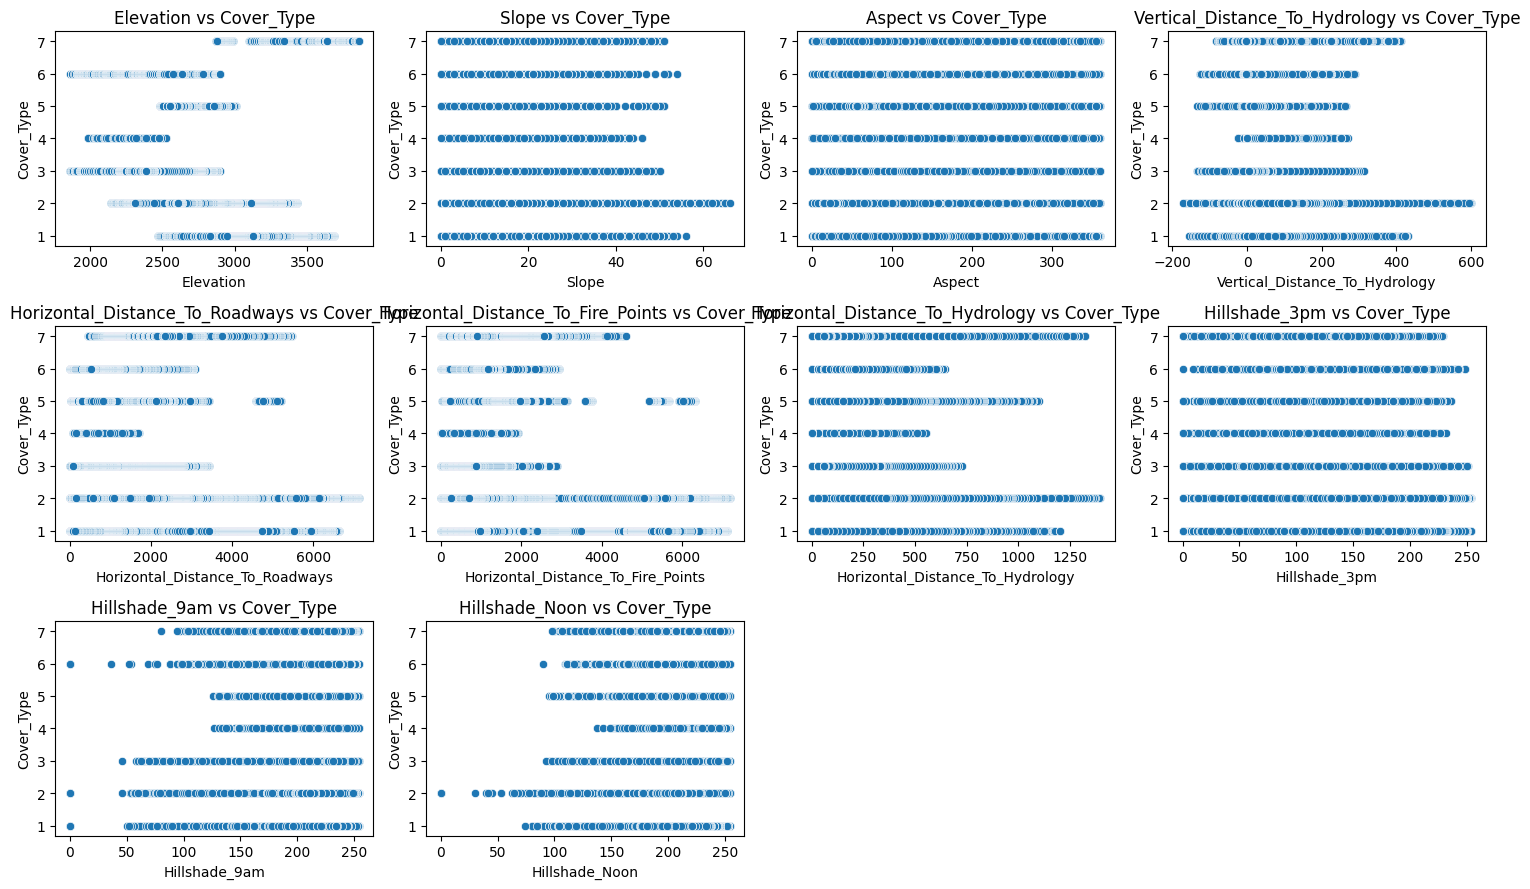

In [37]:
plot_scatterplots(df, ['Elevation','Slope','Aspect','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways', \
                                   'Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Hydrology','Hillshade_3pm', \
                                    'Hillshade_9am','Hillshade_Noon'], target_column='Cover_Type')

Inference:
- Most of the features are spread out and so it suggests that they mght not be linearly separable
- Elevation feature seem to be linearly separable between the classes with a lot of overlap but yet promising
- No notable outliers 

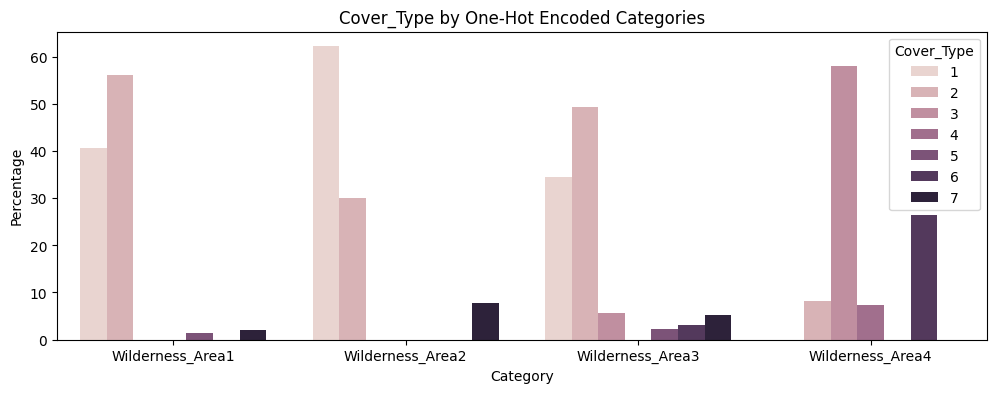

In [45]:
def plot_stacked_bar_chart(df, category_columns, target_column):
    """
    Plot a stacked bar chart showing the distribution of the target variable across one-hot encoded categorical features.
    """
    # Reshape the data for better visualization
    melted_df = pd.melt(df, id_vars=[target_column], value_vars=category_columns, var_name='Category', value_name='Present')
    melted_df = melted_df[melted_df['Present'] == 1]  # Keep only active categories

    # Calculate the percentage distribution
    plot_data = melted_df.groupby(['Category', target_column]).size().reset_index(name='Count')
    plot_data['Percentage'] = plot_data.groupby('Category')['Count'].transform(lambda x: x / x.sum() * 100)

    # Plot stacked bar chart
    plt.figure(figsize=(12, 4))
    sns.barplot(x='Category', y='Percentage', hue=target_column, data=plot_data)
    plt.title(f'{target_column} by One-Hot Encoded Categories')
    plt.ylabel('Percentage')
    # plt.xticks(rotation=45)
    plt.legend(title=target_column)
    plt.show()


plot_stacked_bar_chart(df, ['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4',], target_column='Cover_Type')

Inference:
- Cover Type 1,2 and 7 are in Wilderness Area1 ,2 and 3
- Cover type 3 is found only in Area3 and 4
- Cover type 4 is found only in Area4

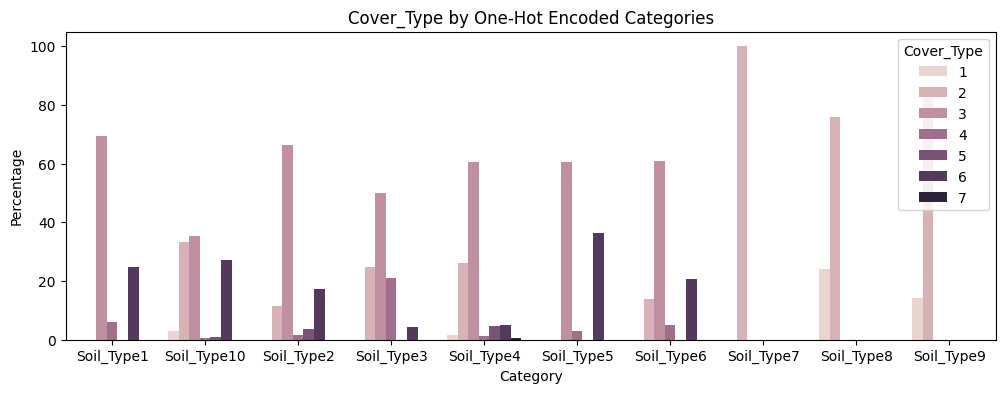

In [47]:
plot_stacked_bar_chart(df, ['Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8','Soil_Type9','Soil_Type10',\
                           ], target_column='Cover_Type')

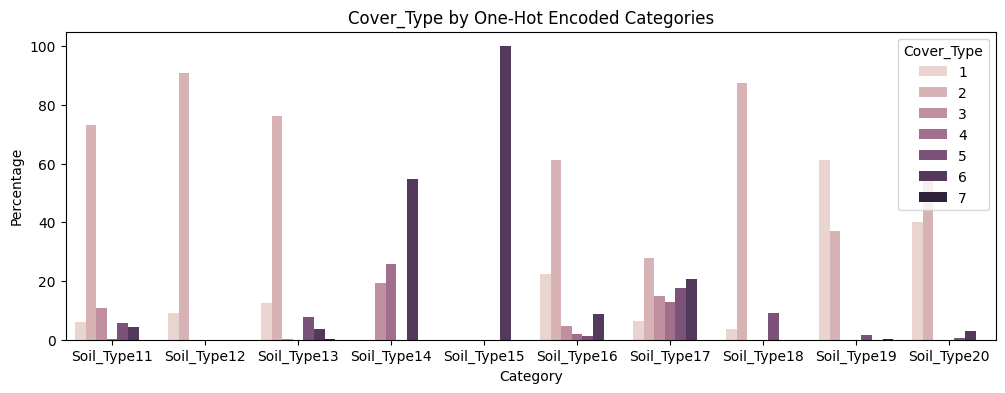

In [ ]:
plot_stacked_bar_chart(df, ['Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19','Soil_Type20',\
                            ], target_column='Cover_Type')

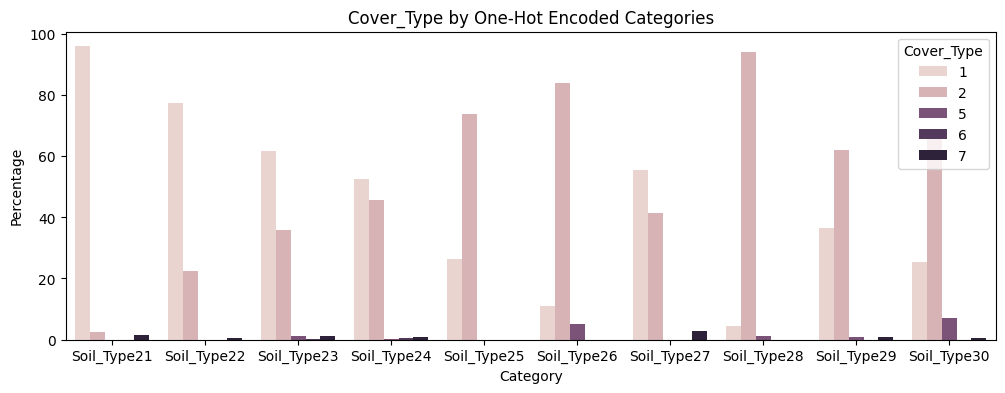

In [50]:
plot_stacked_bar_chart(df, ['Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26','Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30',\
                           ], target_column='Cover_Type')

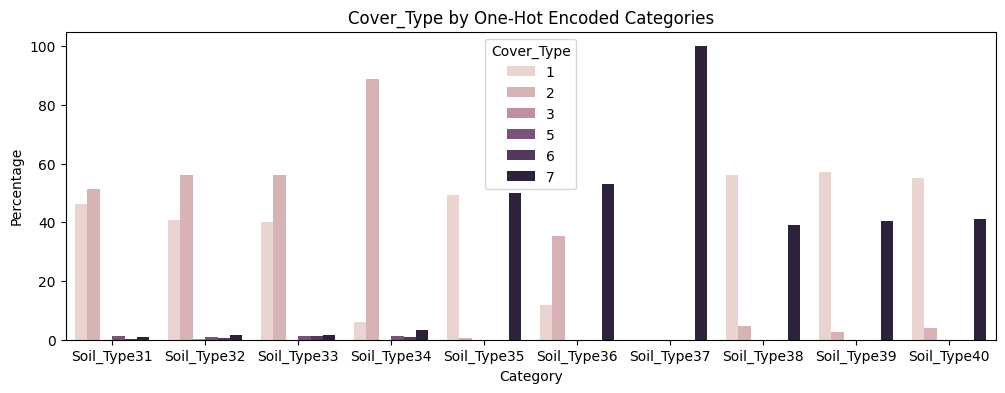

In [49]:
plot_stacked_bar_chart(df, ['Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39','Soil_Type40',\
                            ], target_column='Cover_Type')

Inference:
- Soil Type seems like a good predictor since few soil types seem to host only one or two covertypes in total count

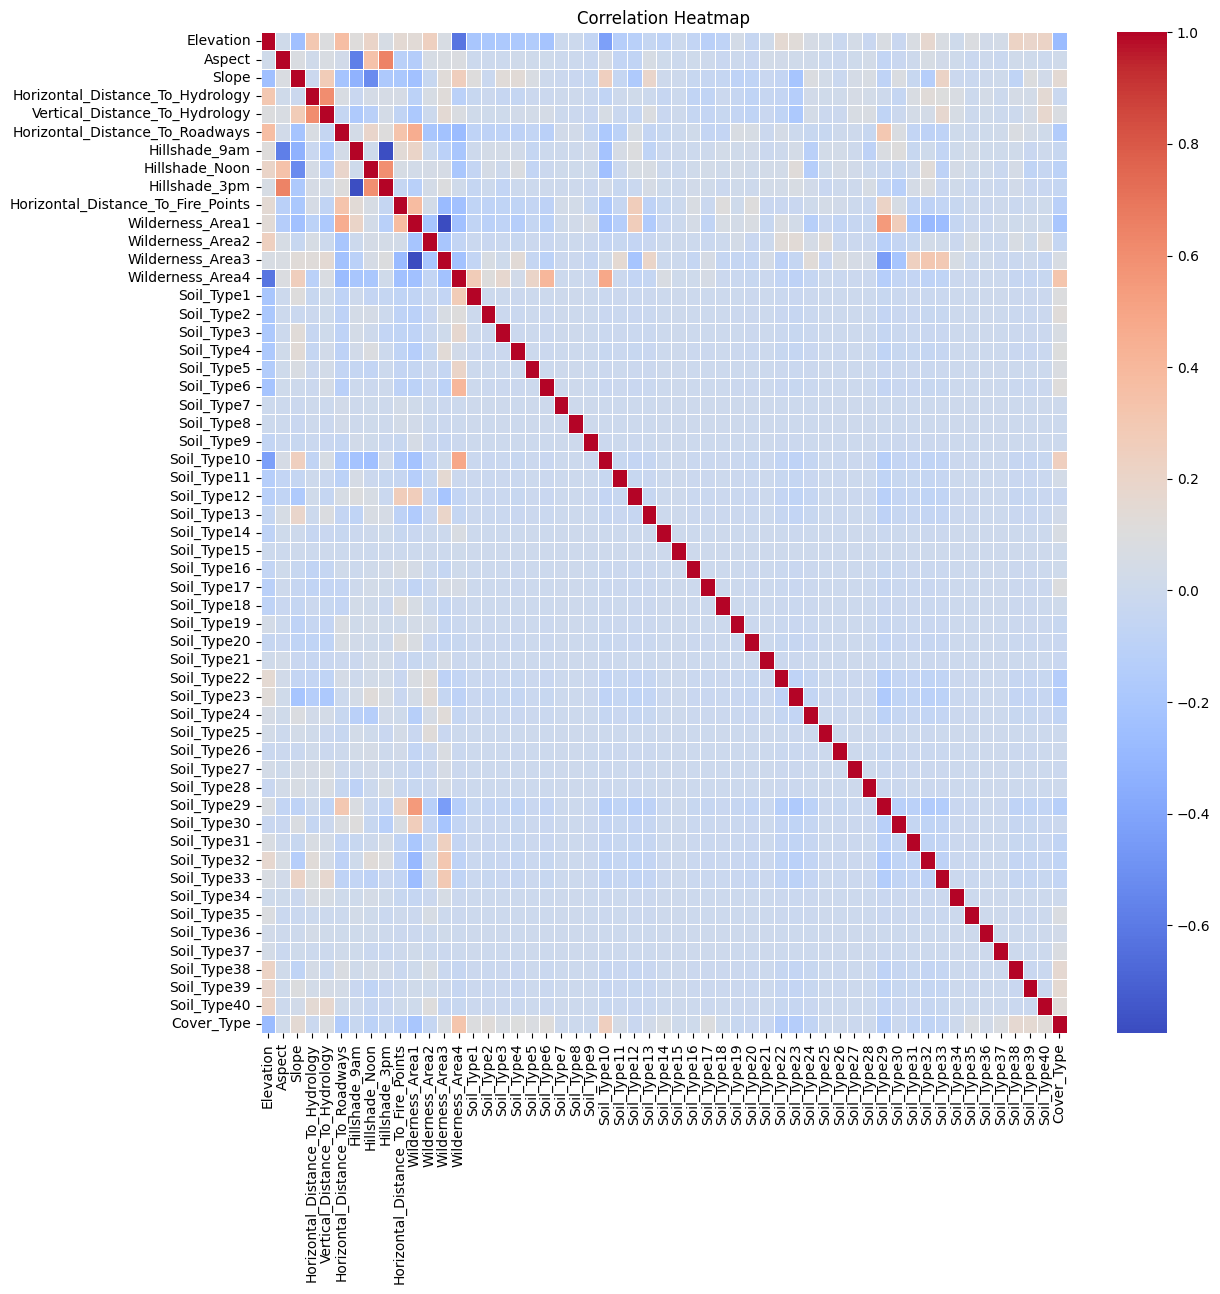

In [59]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(13, 13))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


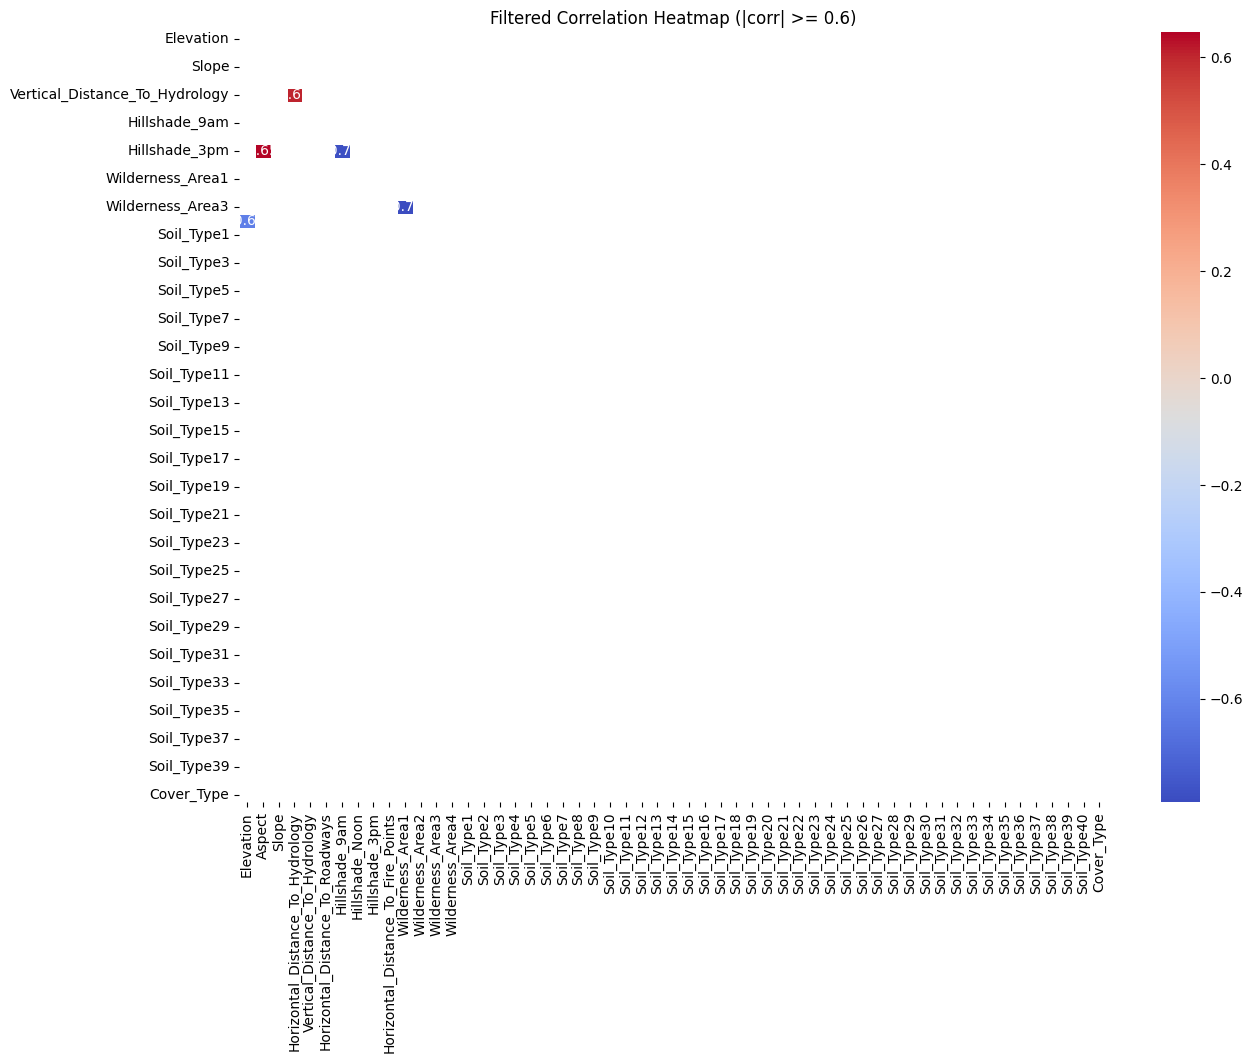

In [61]:
# Compute correlation matrix
correlation_matrix = df.corr()
threshold = 0.6

# Create a mask to hide one half of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the threshold to filter correlations
filtered_corr = correlation_matrix.copy()
filtered_corr[(correlation_matrix < threshold) & (correlation_matrix > -threshold)] = np.nan

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(filtered_corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title(f'Filtered Correlation Heatmap (|corr| >= {threshold})')
plt.show()

Inference:
- Correlations are borderline and only between few variable so no treatment needed
---

<a id="step-4"></a>

### **Step 4: Feature Engineering & Selection**
- Create new features if applicable
    - Evaluate any logical combinations of existing features.
    - Derive meaningful interaction terms or ratios.
        - Example: Elevation difference, slope to distance ratio, etc.
- Select important features (correlation, feature importance)
    - Perform Feature Importance Analysis using models like Random Forest, XGBoost, or Logistic Regression.
    - Evaluate the importance using metrics like Gini importance or Shapley values.
- Apply dimensionality reduction - Optional (PCA, LDA if needed)
    - If there are too many features or correlations, apply PCA (Principal Component Analysis) for continuous data.
    - LDA (Linear Discriminant Analysis) is useful if classification is the goal.

Inference:
 - Since the Forest Cover Type dataset is a well-processed, let's first evaluate the existing features by training a baseline model.
 ---

<a id="step-5"></a>

### **Step 5: Baseline Model and Preprocessing**
- Choose a baseline model (simple logistic regression, decision tree)
- Set up train-test split or cross-validation
- Train and evaluate the baseline model

In [4]:
from sklearn.model_selection import train_test_split

# Features and target separation
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (464809, 54)
Test data shape: (116203, 54)


<a id="baseline"></a>
### BaseLine Models
 - Logistic Regression
 - Random Forest

 Evaluation metrics:
 - Accuracy
 - F1 Score

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [7]:
# Logistic Regression Model
# Initialize and train the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_log = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Logistic Regression Results:
Accuracy: 0.684052907412029
F1 Score: 0.6589080008523914
Confusion Matrix:
 [[29559 12639     5     0     0     0   165]
 [10741 44883   946     0     1    65    25]
 [    0  1972  4581   205     1   392     0]
 [    0    15   341   187     0     6     0]
 [   12  1867    20     0     0     0     0]
 [    1  1650  1647    28     0   146     1]
 [ 3890    79     0     0     0     0   133]]

Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.70      0.68     42368
           2       0.71      0.79      0.75     56661
           3       0.61      0.64      0.62      7151
           4       0.45      0.34      0.39       549
           5       0.00      0.00      0.00      1899
           6       0.24      0.04      0.07      3473
           7       0.41      0.03      0.06      4102

    accuracy                           0.68    116203
   macro avg       0.44      0.36      0.37    116203
weighted avg

In [8]:
# Random Forest Model
# Initialize and train the model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))



Random Forest Results:
Accuracy: 0.9533316695782381
F1 Score: 0.953090124379553
Confusion Matrix:
 [[39889  2376     1     0     6     2    94]
 [ 1300 55120   104     1    54    68    14]
 [    0   122  6866    23     6   134     0]
 [    0     0    58   470     0    21     0]
 [   25   383    20     0  1462     9     0]
 [    5    92   261    19     4  3092     0]
 [  193    28     0     0     0     0  3881]]

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.86      0.89       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg     

Inference:
- Precision above 0.92 across all classes:
- The model is correctly identifying most positive predictions, meaning false positives are low.
- Recall fluctuates, especially in minority classes:
    - This indicates a higher number of false negatives (actual cover types misclassified as others).
    ---

<a id="step-6"></a>

### **Step 6: Model Training & Optimization**
- Train different models (XGBoost, SVM, etc.)
- Perform hyperparameter tuning (GridSearch, RandomSearch, Bayesian Optimization)
- Handle overfitting (regularization, dropout, pruning)
- Compare model performances

Let's proceed with XGBoost and SVM Models and then Hyper-parameter tuning with GridSearch and RandomSearch. 

<a id="xgb"></a>

## XGBoost

In [6]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [7]:
# XGB expects the y values to be numeric and 0 indexed and so below adjustments
# Adjust labels to start from 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1


In [11]:
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train_adj)

y_pred_xgb_adj = xgb_clf.predict(X_test)

# Adjust predictions back to original class values
y_pred_xgb = y_pred_xgb_adj + 1

# Evaluate
print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Results:
Accuracy: 0.8696074972246843
F1 Score: 0.8690230589303299

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.84      0.85     42368
           2       0.87      0.90      0.88     56661
           3       0.89      0.91      0.90      7151
           4       0.88      0.86      0.87       549
           5       0.89      0.61      0.72      1899
           6       0.85      0.80      0.82      3473
           7       0.95      0.91      0.93      4102

    accuracy                           0.87    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.87      0.87      0.87    116203



XGBoost is underperforming RF and it could be due to:
- Random Forest's default settings are robust while XGB's require some hands-on tuning particularly - learning_rate, max_depth, and n_estimators
- XGBoost doesn't apply appropriate class balancing, it may struggle with minority class predictions. RF's random sampling handles this automatically


XGBoost Tuning:
- XGboost does not handle class imbalance (binary or multi-class) well due to the gradient boosting technique where Majority classes will dominate. To mitigate, there is an option to use scale_pos_weight (scale_pos_weight = "Scale Positive Class Weight." - old name when it was used only for binary classificaiton. Name stuck and still used for multi-class as well). 
    - scale_pos_weight forces XGboost to focus on minority which distorts the final probabilities of all the classes so might not be needed in our case since final class probability needs to be its best. 
    - Reference: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
    - Official documentation states that we set max_delta_step=1 which ensures stable training by limiting extreme weight adjustments. 

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Adjust y labels to start from 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1

# Initialize XGBoost with early stopping and max_delta_step
xgb_clf = XGBClassifier(
    objective='multi:softmax',  # Informs XGboost of the multiclass situation
    num_class=7,
    max_delta_step=3,           # Stabilizes training for imbalanced data
    eval_metric='mlogloss',     # Multiclass Log loss: Penalizes confident wrong predictions more heavily. useful when you care about both class prediction and probability calibration
    early_stopping_rounds=20,
    random_state=42
)

# Fit the model
xgb_clf.fit(
    X_train, y_train_adj,
    eval_set=[(X_test, y_test_adj)],
    verbose=False
)

# Predict and evaluate
y_pred_xgb_adj = xgb_clf.predict(X_test)
y_pred_xgb = y_pred_xgb_adj + 1

print("XGBoost Results with Early Stopping and max_delta_step:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Results with Early Stopping and max_delta_step:
Accuracy: 0.8700808068638504
F1 Score: 0.8695187860242448

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.84      0.85     42368
           2       0.87      0.90      0.88     56661
           3       0.89      0.91      0.90      7151
           4       0.89      0.87      0.88       549
           5       0.89      0.62      0.73      1899
           6       0.85      0.80      0.83      3473
           7       0.94      0.91      0.93      4102

    accuracy                           0.87    116203
   macro avg       0.88      0.84      0.86    116203
weighted avg       0.87      0.87      0.87    116203



XGBoost Tuning:
- learning_rate=0.1: Improved convergence speed.
- n_estimators=1000: increase number of trees since it showed promising increase (default LR is 0.3)
- early_stopping_rounds=20: Stops training if no improvement within 20 rounds.

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Adjust y labels to start from 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1

# Calculate scale_pos_weight if needed
scale_pos_weight = len(y_train_adj[y_train_adj == 0]) / len(y_train_adj[y_train_adj != 0])

# Initialize XGBoost with refined parameters
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=7,
    max_delta_step=3,
    learning_rate=0.1,
    n_estimators=1000,
    early_stopping_rounds=20,
    eval_metric='mlogloss',
    random_state=42
)

# Fit the model
xgb_clf.fit(
    X_train, y_train_adj,
    eval_set=[(X_test, y_test_adj)],
    verbose=False
)

# Predict and evaluate
y_pred_xgb_adj = xgb_clf.predict(X_test)
y_pred_xgb = y_pred_xgb_adj + 1

print("XGBoost Results with Adjusted Parameters:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Results with Adjusted Parameters:
Accuracy: 0.9280913573659888
F1 Score: 0.9279316809015661

Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.90      0.92     42368
           2       0.92      0.95      0.93     56661
           3       0.95      0.96      0.95      7151
           4       0.91      0.87      0.89       549
           5       0.92      0.82      0.87      1899
           6       0.92      0.91      0.92      3473
           7       0.97      0.96      0.96      4102

    accuracy                           0.93    116203
   macro avg       0.93      0.91      0.92    116203
weighted avg       0.93      0.93      0.93    116203



XGBoost Tuning:
- learning_rate=0.1: Improved convergence speed.
- n_estimators=500: Reduced the number of trees to prevent inefficiency.
- max_depth=8: Balanced complexity to capture patterns without overfitting.
- min_child_weight=5: Requires more samples per leaf, reducing overfitting.
- reg_alpha=0.5: Applied L1 regularization to further control model complexity.
- colsample_bytree=0.8: Subsamples 80% of features, preventing overfitting.
- early_stopping_rounds=20: Stops training if no improvement within 20 rounds.

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Adjust y labels to start from 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1

# Initialize XGBoost with optimized parameters
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=7,  # Adjust to 7 classes
    learning_rate=0.1,  # Increased learning rate
    n_estimators=500,  # Reduced number of trees
    max_depth=8,  # Moderate depth for balance
    min_child_weight=5,  # Prevents overfitting
    reg_alpha=0.5,  # Light L1 regularization
    colsample_bytree=0.8,  # Column subsampling
    max_delta_step=3,  # Ensures better convergence
    early_stopping_rounds=20,
    eval_metric='mlogloss',
    random_state=42
)

# Fit the model
xgb_clf.fit(
    X_train, y_train_adj,
    eval_set=[(X_test, y_test_adj)],
    verbose=False
)

# Predict and evaluate
y_pred_xgb_adj = xgb_clf.predict(X_test)
y_pred_xgb = y_pred_xgb_adj + 1

print("XGBoost Results with Adjusted Parameters:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Results with Adjusted Parameters:
Accuracy: 0.934726297944115
F1 Score: 0.9345750977121157

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.91      0.93     42368
           2       0.93      0.95      0.94     56661
           3       0.95      0.96      0.95      7151
           4       0.91      0.87      0.89       549
           5       0.92      0.82      0.87      1899
           6       0.92      0.91      0.91      3473
           7       0.97      0.96      0.96      4102

    accuracy                           0.93    116203
   macro avg       0.93      0.91      0.92    116203
weighted avg       0.93      0.93      0.93    116203



Observation:
- XGBoost's best result has been 93% after many attempts and with different hyperparameter tunings. Still the accuracy is lower than the baseline RF model results. We could achieve a higher score but not at the cost of time. we should be able to do better.
---

<a id="svm"></a>

## SVM Classifier Model
 - SVM is sensitive to features scales and so we have to standardize it with StandardScaler or MinMaxScaler
 - I first tried SVC with Linear Kernel but it ran for 1 hour and more. SVMs, especially with a linear kernel, can be extremely slow on large datasets. This is because they involve solving a quadratic optimization problem that doesn't scale well.

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Support Vector Classifier with a linear kernel
svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train_scaled, y_train)

# Predict
y_pred = svc.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Observation:
- Ran for 1 hour and so cancelled

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc_rbf = SVC(kernel='rbf', C=10, gamma='auto', class_weight='balanced', max_iter=1000)
svc_rbf.fit(X_train_scaled, y_train)

# Predict and Evaluate
y_pred = svc_rbf.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Validation Accuracy: 0.3904
Validation F1 Score: 0.2820


Observation:
- Ran for 17 mins with 39% accuracy and 28% F1

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Downsample for faster training
X_train_sample = X_train_scaled[:30000]
y_train_sample = y_train[:30000]

# Train SVM with RBF Kernel
svc_rbf = SVC(kernel='rbf',C=1, gamma='auto', max_iter=10000)
svc_rbf.fit(X_train_sample, y_train_sample)

# Predict and Evluate
y_pred = svc_rbf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.6269
Test F1 Score: 0.6378


Observation:
- SVM has been very slow and high computational needs. Forced to downsample and the highest Accuracy/F1 Score is around 63% which below our baseline - Logistic Regression. SVM is not suitable for this project.
---


<a id="lgbm"></a>

## LightGBM

In [6]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, classification_report


# Adjust labels to be 0-indexed
y_train_lgb = y_train - 1
y_test_lgb = y_test - 1

# Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train_lgb)
test_data = lgb.Dataset(X_test, label=y_test_lgb, reference=train_data)

# Model Parameters
params = {     
    'objective': 'multiclass',  # Define the objective as multiclass classification    
    'num_class': 7,             # number of distinct classes in the dataset    
    'boosting_type': 'gbdt',    # Use Gradient Boosting Decision Trees (GBDT) as the boosting method    
    'metric': 'multi_logloss',  # eval metric as multiclass log loss, which is suitable for classification
    'learning_rate': 0.05,      # Learning rate    
    'n_estimators': 2000,       # boosting iterations (trees) to build; higher values =  higher accuracy&compute    
    'num_leaves': 64,           # leaves per tree; higher values allow more complex models, improving performance on structured data    
    'max_depth': 12,            # Maximum tree depth to prevent excessive growth    
    'is_unbalance': True,       # Automatically adjusts class imbalance by assigning higher weights to minority classes    
    'early_stopping_rounds': 50,# Early stopping to prevent overfitting    
    'verbose': -1               # Suppresses LightGBM warnings 
}

# Train Model
lgb_model = lgb.train(params, train_data, valid_sets=[train_data])

# Predictions
y_pred = lgb_model.predict(X_test)
y_pred_lgb = [list(x).index(max(x)) for x in y_pred]

# Evaluation
accuracy = accuracy_score(y_test_lgb, y_pred_lgb)
f1 = f1_score(y_test_lgb, y_pred_lgb, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test_lgb, y_pred_lgb))


Test Accuracy: 0.9660
Test F1 Score: 0.9660

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96     42368
           1       0.97      0.98      0.97     56661
           2       0.96      0.97      0.97      7151
           3       0.92      0.88      0.90       549
           4       0.94      0.89      0.91      1899
           5       0.95      0.94      0.95      3473
           6       0.98      0.97      0.97      4102

    accuracy                           0.97    116203
   macro avg       0.96      0.94      0.95    116203
weighted avg       0.97      0.97      0.97    116203



Observation:
- Accuracy and F1 score of 96.6% which is the highest we have achieved in this project. 
---
---

<a id="step-7"></a>

### **Step 7: Model Evaluation & Interpretation**
- Evaluate models on test data (Precision, Recall, AUC, Confusion Matrix)
- Compare different models and select the best one
- Analyze feature importance (SHAP, permutation importance)

##### Model Comparison:

- Baseline - Logistic Regression (Acc:68.4% ,F1:65.9%): Baseline model did not perform well for the minority classes and did as poor as 0% (Cover_Type 5). 
- Baseline **Random Forest (Acc:95.3% ,F1:95.3%)**: The second-best model, providing strong baseline performance with minimal tuning. Lowest F1 for an individual class is 85% (Cover_Type 5)

- XGBoost (Acc:93.4% ,F1:93.4%)**: Achieved good results but required extensive hyperparameter tuning to get close to Baseline-RF's performance. Lowest F1 for an individual class is 87% (Cover_Type 5)
- SVM (Acc:62.7% ,F1:63.7%): Computationally expensive, requiring downsampling due to long training times (2+ hours). 

##### **Best Model**
- **LightGBM (Acc:96.6% ,F1:96.6%)**: The best-performing model, balancing accuracy and speed with effective hyperparameter tuning. Lowest F1 for an individual class is 90% (Cover_Type 3)

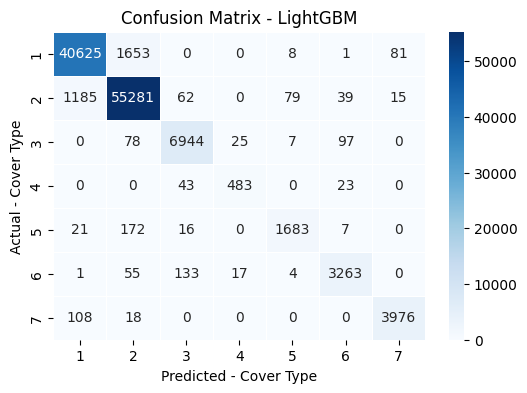

In [10]:
from sklearn.metrics import confusion_matrix

y_pred =  [x + 1 for x in y_pred_lgb]

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, xticklabels=range(1, 8),yticklabels=range(1, 8))
plt.xlabel('Predicted - Cover Type')
plt.ylabel('Actual - Cover Type')
plt.title('Confusion Matrix - LightGBM')
plt.show()

Observations:
- In absolute values, cover type 1 and 2 have the highest misclassified but they represent only 4% of the class
- CoverType 4 and 5 have 10% missclassified while they are the smallest of the minority classes

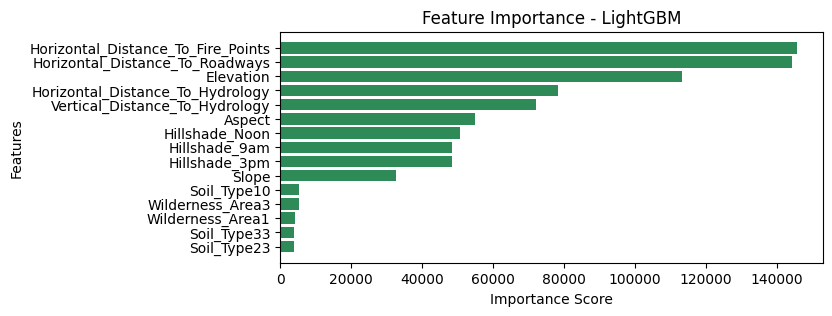

In [16]:
# Extract feature importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgb_model.feature_importance()})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(7, 3))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15], color='seagreen')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - LightGBM')
plt.gca().invert_yaxis()
plt.show()

Observation:
- The one-hot encoded variables Wilderness_area and Soil_Type must be aggregated to see if their importance.

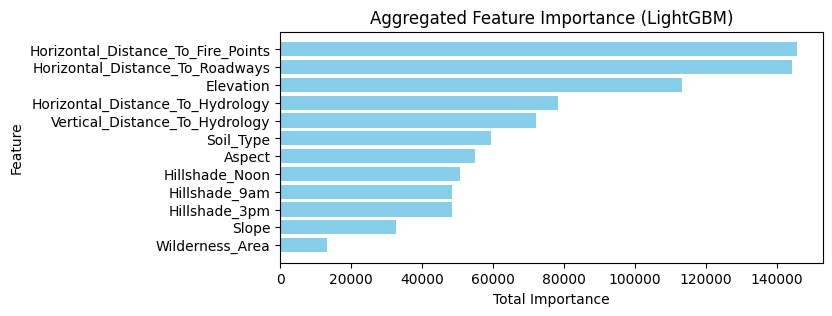

In [27]:


# Extract feature importance
lgb_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgb_model.feature_importance()})

# Identify one-hot encoded categories
soil_type_cols = [col for col in X_train.columns if 'soil_type' in col.lower()]
wilderness_cols = [col for col in X_train.columns if 'wilderness_area' in col.lower()]

# Calculate aggregated importances
aggregated_importances = lgb_importances.copy()

aggregated_importances.loc[aggregated_importances['Feature'].isin(soil_type_cols), 'Feature'] = 'Soil_Type'
aggregated_importances.loc[aggregated_importances['Feature'].isin(wilderness_cols), 'Feature'] = 'Wilderness_Area'

# Sum importances for each category
final_importances = aggregated_importances.groupby('Feature')['Importance'].sum().reset_index()
final_importances = final_importances.sort_values(by='Importance', ascending=False)


# Plot aggregated importances
plt.figure(figsize=(7, 3))
plt.barh(final_importances['Feature'], final_importances['Importance'], color='skyblue')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.title('Aggregated Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.show()

Observation:
- The feature_importance above is the default type and it is the Split Importance. Split Importance counts how many times a feature was used to split data across all the trees in the model. 
- You can also extract:
    - Gain Importance: measures the cumulative gain (reduction in loss) that resulted from using a particular feature for splits. It reflects how much that feature improved the model’s predictions.
    - Cover Importance: indicates the number of data points (samples) affected by splits using the feature. Useful for understanding how broadly a feature impacts predictions

All said, the value is difficult to interpret. Like above, the top variable has a value 140K. what does this 140k represent and kind of raises more questions. Hence we can standardize the importance such that the importances sum to 1 and convert the fractions to percentage as below.

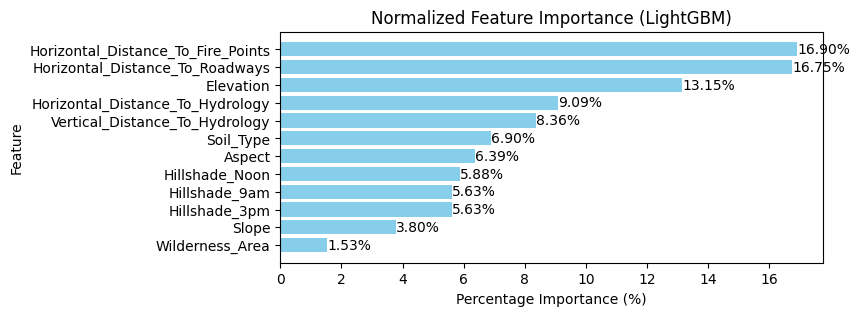

In [32]:

# Calculate percentage importance
final_importances['Percentage_Importance'] = (final_importances['Importance'] / final_importances['Importance'].sum()) * 100

# Plot the normalized importances
plt.figure(figsize=(7, 3))
plt.barh(final_importances['Feature'], final_importances['Percentage_Importance'], color='skyblue')
for index, value in enumerate(final_importances['Percentage_Importance']):
    plt.text(value, index, f'{value:.2f}%', va='center', fontsize=10)
plt.xlabel('Percentage Importance (%)')
plt.ylabel('Feature')
plt.title('Normalized Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.show()


Inference:

From the feature importance values and the variable names, we can draw the following inferences about what influences forest type:

- Distance to Fire Points and Roadways (17% each)
Proximity to human activities (fire points and roadways) seem to play a significant role in determining the forest type. Forests near roads may have different species due to accessibility, human interventions, and potential deforestation. Fire management areas may also have specific vegetation patterns.

- Elevation (13%)
Elevation strongly impacts the forest ecosystem due to temperature, oxygen levels, and soil type variations.

- Distance to Hydrology (Horizontal - 9%, Vertical - 8%)
The proximity to water bodies significantly affects vegetation growth. 

- Soil Type (7%)
Soil composition dictates which types of vegetation can thrive due to difference in nutrients, pH levels, and drainage properties.

- Aspect (6%)
The direction a slope faces (aspect) influences sunlight exposure, temperature, and moisture, impacting the forest type. 
---


<a id="step-8"></a>

### **Step 8: Discussion and Conclusion** 


In this project, we explored multiple machine learning models to classify forest cover types using structured tabular data. The best-performing model was **LightGBM**, achieving **96.6% accuracy and F1 score**, outperforming all other models in both accuracy and training efficiency.  

#### Key Takeaways  
- **Ensemble models (RF, XGBoost, LightGBM)** performed significantly better than SVM, likely due to the structured nature of the dataset.  
- **Hyperparameter tuning** played a crucial role, particularly in LightGBM, where adjustments such as increasing `n_estimators` and optimizing `num_leaves` boosted performance.  
- **Computational efficiency** was an important consideration; LightGBM provided the best trade-off between speed and accuracy.  

#### Key Takeaways from Feature Importance Analysis:
- Human Influence: Proximity to Fire Points (17%) and Roadways (17%) strongly impacts forest types.
- Elevation Matters: Elevation (13%) is a major factor influencing vegetation patterns.
- Water Proximity: Horizontal and Vertical Distance to Hydrology (17%) are significant, reflecting the role of water availability.
- Soil and Sunlight: Soil Type (7%) and Hillshade (18%) affect tree growth based on nutrient availability and sunlight exposure.
- Limited Wilderness Impact: Wilderness Area (2%) has minimal influence compared to natural and human factors.

This project demonstrated the effectiveness of **ensemble-based tree models** for structured classification tasks and highlighted the importance of **hyperparameter tuning and computational efficiency** in selecting the best model.  

## **LightGBM is the Best Model**
- Highest Accuracy: Achieved 96.6% accuracy, outperforming other models.
- Efficient Training: Faster and more memory-efficient than XGBoost and SVM.
- Effective with Imbalance: Handled class imbalance well using built-in techniques.
- Optimal Tuning: Improved performance through hyperparameter tuning with minimal effort.

---

<a id="step-9"></a>

### **Step 9: Deployment  & Model Monitoring** 

Deployment and monitoring are essential for applying the model to real-world scenarios, ensuring it remains accurate and reliable. 
While this step is **out of scope** for this project, a typical deployment process involves:

- Model Deployment: Integrating the trained model into production systems using platforms like AWS, Azure, or GCP.
- API Creation: Exposing the model as an API for real-time predictions.
- Monitoring: Tracking performance metrics (e.g., accuracy, latency) using monitoring tools.
- Retraining: Periodically retraining the model with new data to maintain accuracy.
- Drift Detection: Identifying data or concept drift to trigger model updates.
    - Drift refers to the change in data patterns over time, leading to model performance degradation. It can be corrected by retraining the model with updated data, using adaptive learning, or applying drift detection algorithms to trigger updates.

A data scientist collaborates with MLOps engineers to ensure smooth deployment, define monitoring KPIs, and create retraining pipelines.